In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


In [2]:
os.chdir("C:\\Users\\Admin\\FingerprintClassification\\model")
from preprocess.preprocessing3 import preprocessing_normal

In [3]:
print(os.getcwd())

C:\Users\Admin\FingerprintClassification\model


In [3]:
def read_data(label2num):
    id_anh = 0
    X=[]
    Y=[]
    #output_folder = "C:\\Users\\ADMIN\\FingerprintClassification\\model\\preprocessed_fingerprint"
    for label in os.listdir(os.path.join("dataset\\preprocessed_fingerprint")):
        id_anh+=1
        img = cv2.imread(os.path.join('dataset\\preprocessed_fingerprint',str(id_anh)+'.png'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img = img.flatten()
        X.append(img)
        Y.append(label2num["fingerprint"])
        if id_anh>=4000: break
    for label in os.listdir(os.path.join("dataset\\preprocessed_fingerprint")):
        id_anh+=1
        img = cv2.imread(os.path.join('dataset\\preprocessed_fingerprint',str(id_anh)+'.png'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img = img.flatten()
        X.append(img)
        Y.append(label2num["fingerprint_noise"])
        if id_anh>=8000: break
    return X,Y


In [4]:
label2num = {'fingerprint_noise':0, 'fingerprint':1}
X, Y = read_data(label2num)
print(len(X))
print(len(Y))

8000
8000


(256, 256)
0


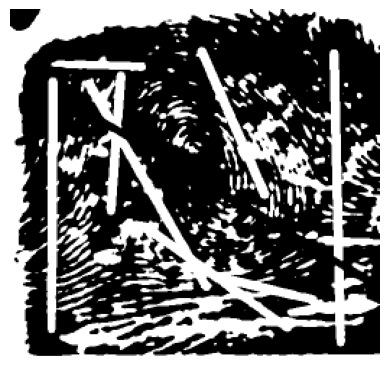

In [5]:
plt.imshow(X[7999], cmap='gray')
print(X[7999].shape)
plt.axis("off")
print(Y[7999])

In [6]:
def extract_sift(X):
    image_descriptors = []
    sift = cv2.SIFT_create()
    #sift = cv2.SIFT_create(nfeatures=400)
    for i in range(len(X)):
        _, des = sift.detectAndCompute(X[i], None)
        '''img_with_keypoints = cv2.drawKeypoints(X[i], _, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
        plt.figure(figsize=(10, 10)) 
        plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)) 
        plt.title(f'Image {i} with SIFT features')'''
        image_descriptors.append(des)
    return image_descriptors

In [7]:
def extract_orb(X):
    image_descriptors = []
    orb = cv2.ORB_create()
    #sift = cv2.SIFT_create(nfeatures=400)
    for i in range(len(X)):
        _, des = orb.detectAndCompute(X[i], None)
        '''img_with_keypoints = cv2.drawKeypoints(X[i], _, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
        plt.figure(figsize=(10, 10)) 
        plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)) 
        plt.title(f'Image {i} with SIFT features')'''
        image_descriptors.append(des)
    return image_descriptors

In [9]:
#orb, nếu dùng orb thì chạy đến đây, lướt xuống đoạn dưới để tìm orb tiếp
image_descriptors = extract_orb(X)
print(len(image_descriptors))
for i in range(0,20):
    print('anh {} gom {} features'.format(i, len(image_descriptors[i])))

8000
anh 0 gom 477 features
anh 1 gom 473 features
anh 2 gom 475 features
anh 3 gom 475 features
anh 4 gom 471 features
anh 5 gom 473 features
anh 6 gom 475 features
anh 7 gom 468 features
anh 8 gom 476 features
anh 9 gom 475 features
anh 10 gom 475 features
anh 11 gom 475 features
anh 12 gom 474 features
anh 13 gom 474 features
anh 14 gom 469 features
anh 15 gom 475 features
anh 16 gom 475 features
anh 17 gom 472 features
anh 18 gom 476 features
anh 19 gom 475 features


In [16]:
image_descriptors = extract_sift(X)
print(len(image_descriptors))
for i in range(0,20):
    print('anh {} gom {} features'.format(i, len(image_descriptors[i])))


8000
anh 0 gom 3142 features
anh 1 gom 2760 features
anh 2 gom 1758 features
anh 3 gom 2230 features
anh 4 gom 2565 features
anh 5 gom 2222 features
anh 6 gom 1404 features
anh 7 gom 3037 features
anh 8 gom 2436 features
anh 9 gom 2026 features
anh 10 gom 1890 features
anh 11 gom 2360 features
anh 12 gom 2773 features
anh 13 gom 1388 features
anh 14 gom 2418 features
anh 15 gom 2473 features
anh 16 gom 2317 features
anh 17 gom 1473 features
anh 18 gom 1123 features
anh 19 gom 2136 features


In [38]:
with open('imagepkl/sift.pkl', 'wb') as f:
    pickle.dump(image_descriptors, f)

NameError: name 'image_descriptors' is not defined

In [5]:
from sklearn.decomposition import PCA
def pca_sift(image_descriptors):
    image_descriptors_pca = []
    for des in image_descriptors:
        pca = PCA(n_components=32)

    # Fit và transform dữ liệu
        pca.fit(des)
        des_pca = pca.transform(des)
        image_descriptors_pca.append(des_pca)
    return image_descriptors_pca

In [40]:
with open('imagepkl/sift.pkl', 'rb') as f:
    loaded_imgdes = pickle.load(f)

EOFError: Ran out of input

In [7]:
image_descriptors_pca = pca_sift(loaded_imgdes)

In [22]:
for i in range(0,20):
    print('anh {} gom {} features'.format(i, len(image_descriptors_pca[i][0])))


anh 0 gom 32 features
anh 1 gom 32 features
anh 2 gom 32 features
anh 3 gom 32 features
anh 4 gom 32 features
anh 5 gom 32 features
anh 6 gom 32 features
anh 7 gom 32 features
anh 8 gom 32 features
anh 9 gom 32 features
anh 10 gom 32 features
anh 11 gom 32 features
anh 12 gom 32 features
anh 13 gom 32 features
anh 14 gom 32 features
anh 15 gom 32 features
anh 16 gom 32 features
anh 17 gom 32 features
anh 18 gom 32 features
anh 19 gom 32 features


In [41]:

all_descriptors = [dess for des in image_descriptors_pca if des is not None for dess in des]
#all_descriptors = [dess for des in loaded_imgdes if des is not None for dess in des]
len(all_descriptors)

13563286

In [ ]:
#orb, xong nhảy xuống đây

all_descriptors = [dess for des in image_descriptors if des is not None for dess in des]
#all_descriptors = [dess for des in loaded_imgdes if des is not None for dess in des]
len(all_descriptors)

3789142

In [11]:
def kmeans_bow(all_descriptors, numberofclus):
    bow_dict = []
    kmeans = KMeans(n_clusters=numberofclus)
    kmeans.fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

In [12]:
num_cluster=30
if not os.path.isfile('ml_data/bow_vector_cluster_30_orb.pkl'):
    BoW = kmeans_bow(all_descriptors, num_cluster)
    pickle.dump(BoW, open('ml_data/bow_vector_cluster_30_orb.pkl', 'wb'))
else:
    BoW = pickle.load(open('ml_data/bow_vector_cluster_30_orb.pkl', 'rb'))
print(len(BoW))

30


In [13]:
from sklearn.preprocessing import normalize
def bow_vector(image_descriptors_pca, BoW, num_cluster):
    X_features = []
    for i in range(len(image_descriptors_pca)):
        features = np.array([0]*num_cluster)

        if image_descriptors_pca[i] is not None:
            distance = cdist(image_descriptors_pca[i], BoW)
            argmin = np.argmin(distance, axis = 1)
            for j in argmin:
                features[j]+=1
        X_features.append(features)


    #resize the vector to be more compatible with the normalize function
    #X_features = np.array(X_features)
    #X_features = X_features.reshape(1, -1)

    #Normalizing
    X_features = normalize(X_features, norm='l2', axis=1)
    
    return X_features

In [14]:
#orb
X_features = bow_vector(image_descriptors, BoW, num_cluster)
#X_features = bow_vector(loaded_imgdes, BoW, num_cluster)
print(X_features[4800])

[0.18700524 0.11000308 0.19800554 0.143004   0.18700524 0.143004
 0.16500462 0.12100339 0.2750077  0.17600493 0.16500462 0.143004
 0.25300708 0.16500462 0.22000616 0.25300708 0.20900585 0.18700524
 0.16500462 0.09900277 0.19800554 0.1320037  0.09900277 0.20900585
 0.15400431 0.23100647 0.09900277 0.19800554 0.28600801 0.06600185]


In [45]:
X_features = bow_vector(image_descriptors_pca, BoW, num_cluster)
#X_features = bow_vector(loaded_imgdes, BoW, num_cluster)
print(X_features[4800])

[0.16932601 0.065849   0.0423315  0.14110501 0.18343651 0.08936651
 0.028221   0.0611455  0.35746602 0.08936651 0.34805902 0.25869252
 0.12699451 0.009407   0.009407   0.21165751 0.075256   0.08936651
 0.047035   0.09877351 0.037628   0.10347701 0.047035   0.14110501
 0.13169801 0.11758751 0.075256   0.14110501 0.35276252 0.18814001
 0.0705525  0.09877351 0.15051201 0.13169801 0.08936651 0.0611455
 0.11758751 0.12699451 0.19754701 0.31983802]


In [18]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score


In [17]:
X_train = []
X_test = []
Y_train = []
Y_test = []
X_valid = []
Y_valid = []
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size = 0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

print(len(X_train), " ",len(X_valid), " ", len(X_test))

4800   1600   1600


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.svm import SVC

In [23]:
lgbm = lgb.LGBMClassifier(class_weight="balanced").fit(X_train, Y_train)
print(lgbm.score(X_train, Y_train))
print(lgbm.score(X_valid, Y_valid))
print(lgbm.score(X_test, Y_test))

[LightGBM] [Info] Number of positive: 2395, number of negative: 2405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
0.9589583333333334
0.68
0.67


In [22]:
log = LogisticRegression().fit(X_train, Y_train)
print(log.score(X_train, Y_train))
print(log.score(X_valid, Y_valid))
print(log.score(X_test, Y_test))

0.7010416666666667
0.68875
0.680625


In [24]:
clf = AdaBoostClassifier(algorithm='SAMME')
clf.fit(X_train, Y_train)
print(clf.score(X_train, Y_train))
print(clf.score(X_valid, Y_valid))
print(clf.score(X_test, Y_test))

0.6997916666666667
0.6625
0.668125


In [25]:
dtree = DecisionTreeClassifier().fit(X_train, Y_train)
print(dtree.score(X_train, Y_train))
print(dtree.score(X_valid, Y_valid))
print(dtree.score(X_test, Y_test))

1.0
0.609375
0.5875


In [26]:
reg = LinearRegression().fit(X_train, Y_train)
print(reg.score(X_train, Y_train))
print(reg.score(X_valid, Y_valid))
print(reg.score(X_test, Y_test))

0.21623623611348775
0.20041509016196846
0.19264245576333183


In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,Y_train)
print(knn.score(X_train, Y_train))
print(knn.score(X_valid, Y_valid))
print(knn.score(X_test, Y_test))

0.7572916666666667
0.629375
0.63375


In [28]:
rf = RandomForestClassifier(n_estimators=12,max_depth=15)
rf.fit(X_train, Y_train)
print(rf.score(X_train, Y_train))
print(rf.score(X_valid, Y_valid))
print(rf.score(X_test, Y_test))

0.9852083333333334
0.656875
0.649375


In [41]:
from sklearn.metrics import classification_report

In [42]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Tính các chỉ số
print("Báo cáo đánh giá trên tập huấn luyện:")
print(classification_report(Y_train, y_pred_train))

print("Báo cáo đánh giá trên tập kiểm tra:")
print(classification_report(Y_test, y_pred_test))

Báo cáo đánh giá trên tập huấn luyện:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3204
           1       1.00      1.00      1.00      3196

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400

Báo cáo đánh giá trên tập kiểm tra:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       796
           1       0.98      0.98      0.98       804

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [29]:
sv = SVC(kernel = 'rbf')
sv.fit(X_train, Y_train)
print(sv.score(X_train, Y_train))
print(sv.score(X_valid, Y_valid))
print(sv.score(X_test, Y_test))

0.81
0.701875
0.6925


In [46]:

testing = []
for label in os.listdir(os.path.join("..//testjuan")):
    img = cv2.imread(os.path.join('..//testjuan',label))
    testing.append(img)
    print(label)
    #bbbb = cv2.imread("anhtest2.png")
my_X=preprocessing_normal(testing)
#sift
my_image_descriptor = extract_sift(my_X)
my_image_descriptor_pca = pca_sift(my_image_descriptor)
my_X_features = bow_vector(my_image_descriptor_pca, BoW, num_cluster)
#orb...

s1.png
s2.png
s3.jpg
s4.jpg
s5.jpg
t1.png
t2.jpg
t3.png
t4.png
t5.png
t6.png


In [55]:
ypred = sv.predict(my_X_features)
print("svm ", ypred)
ypred2 = rf.predict(my_X_features)
print("rf ", ypred2)
ypred3 = reg.predict(my_X_features)
print("reg ", ypred3)
ypred4 = knn.predict(my_X_features)
print("knn ", ypred4)

svm  [0 1 0 0 0 1 0 1 1 0 0]
rf  [0 1 0 0 1 1 0 1 1 0 0]
reg  [-0.17208924  1.06634342  0.2684276  -0.0630272   0.60370679  0.88460964
 -0.04027171  0.79579199  0.62296169  0.14819705  0.07763767]
knn  [0 1 0 0 0 1 0 1 1 0 0]


In [56]:
#lưu mô hình, tune xong mới lưu
pickle.dump(sv, open('ml_data/svm.pkl', 'wb'))
pickle.dump(rf, open('ml_data/rf.pkl', 'wb'))
pickle.dump(reg, open('ml_data/reg.pkl', 'wb'))
pickle.dump(knn, open('ml_data/knn.pkl', 'wb'))